# Example-56: Trajectory (Differentiable trajectory generation)

In [1]:
# In this example usage of differentiable trajectory generators is illustrated
# This generators can be defined to genetate parametic trajectories at one or several observation locations
# Given initial condition, number of iterations and deviation variables, generators return corresponding orbit data 
# Generators are differentiable with respect to initial conditions and parametes

In [2]:
# Import

import torch

from pathlib import Path

from matplotlib import pyplot as plt

from model.library.line import Line
from model.library.corrector import Corrector

from model.command.external import load_lattice
from model.command.build import build
from model.command.wrapper import group
from model.command.orbit import orbit
from model.command.tune import tune
from model.command.mapping import mapping
from model.command.trajectory import trajectory

torch.set_printoptions(linewidth=128)

In [3]:
# Build and setup lattice

# Load ELEGANT table

path = Path('ic.lte')
data = load_lattice(path)

# Build ELEGANT table

ring:Line = build('RING', 'ELEGANT', data)
ring.flatten()

# Merge drifts

ring.merge()

# Turn off sextupoles and set linear dipoles

for element in ring: 
    if element.__class__.__name__ == 'Sextupole':
        element.ms = 0.0
    if element.__class__.__name__ == 'Dipole':
        element.linear = True     

# Add corrector

corrector = Corrector('CXY')
ring.append(corrector)

# Split BPMs

ring.split((None, ['BPM'], None, None))

# Roll lattice start

ring.roll(1)

# Split lattice into lines by BPMs

ring.splice()

# Set number of elements of different kinds

nb = ring.describe['BPM']
nq = ring.describe['Quadrupole']
ns = ring.describe['Sextupole']

In [4]:
# One turn map transport

corrector.cx = 0.0
corrector.cy = 0.0

state = torch.tensor([+1.0E-3, -1.0E-4, -1.0E-3, +1.0E-4], dtype=torch.float64)

# Direct line tracking

print(torch.stack([state, ring(state)]))
print()

# Mapping wrapper

probe = 0
other = len(ring) - 1
transformation, *_ = mapping(ring, probe, other, matched=False)
print(torch.stack([state, transformation(state)]))
print()

# Trajectory generator

transformation = trajectory(ring, [probe],  matched=False)
print(transformation(1, state))
print()

tensor([[ 0.0010, -0.0001, -0.0010,  0.0001],
        [-0.0042,  0.0085, -0.0041, -0.0059]], dtype=torch.float64)

tensor([[ 0.0010, -0.0001, -0.0010,  0.0001],
        [-0.0042,  0.0085, -0.0041, -0.0059]], dtype=torch.float64)

tensor([[ 0.0010, -0.0001, -0.0010,  0.0001],
        [-0.0042,  0.0085, -0.0041, -0.0059]], dtype=torch.float64)



In [5]:
# One turn map transport (closed orbit)

corrector.cx = +100.0E-6
corrector.cy = -100.0E-6

# Compute closed orbit

guess = torch.tensor([0.0, 0.0, 0.0, 0.0], dtype=torch.float64)
guess, *_ = orbit(ring, guess, [], limit=32, epsilon=1.0E-12, full=False)

# Initial state around closed orbit

state = torch.tensor([1.0E-3, 0.0, -1.0E-3, 0.0], dtype=torch.float64)

# Direct line tracking

print(torch.stack([state, ring(state + guess) - guess]))
print()

# Mapping wrapper (matched)
# Note, mapping can be used to generate trajectory at a given location
# But, for matched case, closed orbit will be computed on each invocation

probe = 0
other = len(ring) - 1
transformation, *_ = mapping(ring, probe, other, matched=True, guess=guess, limit=32, epsilon=1.0E-12)
print(torch.stack([state, transformation(state)]))
print()

# Trajectory generator (matched)

transformation = trajectory(ring, [probe],  matched=True, guess=guess, limit=32, epsilon=1.0E-12)
print(transformation(1, state))
print()

tensor([[ 0.0010,  0.0000, -0.0010,  0.0000],
        [-0.0045,  0.0090, -0.0039, -0.0056]], dtype=torch.float64)

tensor([[ 0.0010,  0.0000, -0.0010,  0.0000],
        [-0.0045,  0.0090, -0.0039, -0.0056]], dtype=torch.float64)

tensor([[ 0.0010,  0.0000, -0.0010,  0.0000],
        [-0.0045,  0.0090, -0.0039, -0.0056]], dtype=torch.float64)



In [6]:
# One turn map transport (closed orbit, parametric)

corrector.cx = +100.0E-6
corrector.cy = -100.0E-6

# Compute closed orbit

guess = torch.tensor([0.0, 0.0, 0.0, 0.0], dtype=torch.float64)
guess, *_ = orbit(ring, guess, [], limit=32, epsilon=1.0E-12, full=False)

# Initial state around closed orbit

state = torch.tensor([1.0E-3, 0.0, -1.0E-3, 0.0], dtype=torch.float64)

# Set random deviations parameters

kn = 0.01*torch.randn(nq, dtype=torch.float64)
ks = 0.01*torch.randn(nq, dtype=torch.float64)

# Mapping wrapper (matched, parametric)

probe = 0
other = len(ring) - 1
transformation, *_ = mapping(ring, probe, other, ('kn', ['Quadrupole'], None, None), ('ks', ['Quadrupole'], None, None), matched=True, guess=guess, limit=32, epsilon=1.0E-12)
print(torch.stack([state, transformation(state, 0*kn, 0*ks)]))
print(torch.stack([state, transformation(state, 1*kn, 1*ks)]))
print()

# Trajectory generator (matched, parametric)

transformation = trajectory(ring, [probe],  ('kn', ['Quadrupole'], None, None), ('ks', ['Quadrupole'], None, None), matched=True, guess=guess, limit=32, epsilon=1.0E-12)
print(transformation(1, state, 0.0*kn, 0.0*ks))
print(transformation(1, state, 1.0*kn, 1.0*ks))
print()

tensor([[ 0.0010,  0.0000, -0.0010,  0.0000],
        [-0.0045,  0.0090, -0.0039, -0.0056]], dtype=torch.float64)
tensor([[ 0.0010,  0.0000, -0.0010,  0.0000],
        [-0.0045,  0.0090, -0.0038, -0.0054]], dtype=torch.float64)

tensor([[ 0.0010,  0.0000, -0.0010,  0.0000],
        [-0.0045,  0.0090, -0.0039, -0.0056]], dtype=torch.float64)
tensor([[ 0.0010,  0.0000, -0.0010,  0.0000],
        [-0.0045,  0.0090, -0.0038, -0.0054]], dtype=torch.float64)



In [7]:
# Several observation locations (closed orbit, parametric)

corrector.cx = +100.0E-6
corrector.cy = -100.0E-6

# Initial state around closed orbit

state = torch.tensor([1.0E-3, 0.0, -1.0E-3, 0.0], dtype=torch.float64)

# Set random deviations parameters

kn = 0.01*torch.randn(nq, dtype=torch.float64)
ks = 0.01*torch.randn(nq, dtype=torch.float64)

# Mapping wrapper for one turn (matched, parametric)

t1, *_ = mapping(ring, 0, 0, ('kn', ['Quadrupole'], None, None), ('ks', ['Quadrupole'], None, None), matched=False, limit=32, epsilon=1.0E-12)
t2, *_ = mapping(ring, 1, len(ring) - 1, ('kn', ['Quadrupole'], None, None), ('ks', ['Quadrupole'], None, None), matched=True, limit=32, epsilon=1.0E-12)

print(torch.stack([state, local := t1(state, 0*kn, 0*ks), t2(local, 0*kn, 0*ks)]))
print(torch.stack([state, local := t1(state, 1*kn, 1*ks), t2(local, 1*kn, 1*ks)]))
print()

# Trajectory generator (matched, parametric)

transformation = trajectory(ring, [0, 1],  ('kn', ['Quadrupole'], None, None), ('ks', ['Quadrupole'], None, None), matched=True, limit=32, epsilon=1.0E-12)

print(transformation(1, state, 0.0*kn, 0.0*ks))
print(transformation(1, state, 1.0*kn, 1.0*ks))
print()

tensor([[ 0.0010,  0.0000, -0.0010,  0.0000],
        [ 0.0034, -0.0066,  0.0020,  0.0045],
        [-0.0045,  0.0090, -0.0039, -0.0056]], dtype=torch.float64)
tensor([[ 0.0010,  0.0000, -0.0010,  0.0000],
        [ 0.0034, -0.0066,  0.0020,  0.0045],
        [-0.0044,  0.0088, -0.0039, -0.0056]], dtype=torch.float64)

tensor([[ 0.0010,  0.0000, -0.0010,  0.0000],
        [ 0.0034, -0.0066,  0.0020,  0.0045],
        [-0.0045,  0.0090, -0.0039, -0.0056]], dtype=torch.float64)
tensor([[ 0.0010,  0.0000, -0.0010,  0.0000],
        [ 0.0034, -0.0066,  0.0020,  0.0045],
        [-0.0044,  0.0088, -0.0039, -0.0056]], dtype=torch.float64)



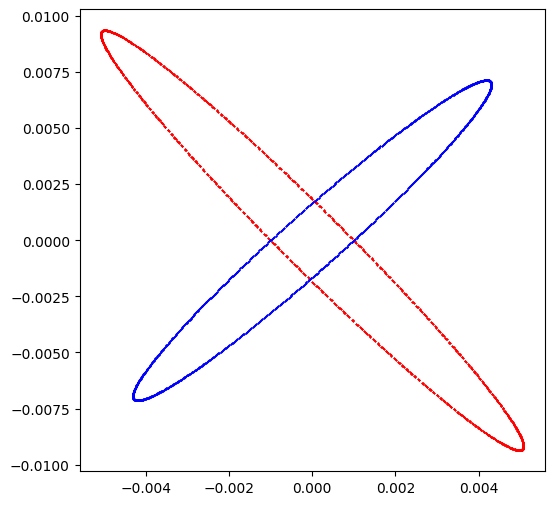

In [8]:
# Multi-turn trajectory generator (single location)

corrector.cx = 0.0
corrector.cy = 0.0

transformation = trajectory(ring, [0])

state = torch.tensor([1.0E-3, 0.0, -1.0E-3, 0.0], dtype=torch.float64)
qx, px, qy, py = transformation(2**10, state).T

plt.figure(figsize=(6, 6))
plt.errorbar(qx, px, color='red', fmt=' ', marker='x', ms=1)
plt.errorbar(qy, py, color='blue', fmt=' ', marker='x', ms=1)
plt.show()

torch.Size([2048, 4])
torch.Size([2, 1024, 4])


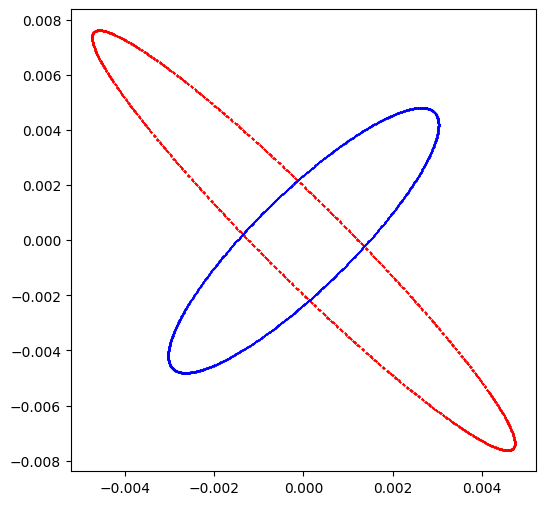

In [9]:
# Multi-turn trajectory generator (several locations)

corrector.cx = 0.0
corrector.cy = 0.0

# Set list of observation locations and trajectory generator

locations = [0, 1]
transformation = trajectory(ring, locations)

# Define initial state

state = torch.tensor([1.0E-3, 0.0, -1.0E-3, 0.0], dtype=torch.float64)

# Generate orbit and drop the last value

*out, _ = transformation(2**10, state)
out = torch.stack(out)
print(out.shape)

# Group by observation point

out = out.reshape(-1, len(locations), 4).swapaxes(0, 1)
print(out.shape)

# Plot trajectory at the second observation location

_, out = out
qx, px, qy, py = out.T

plt.figure(figsize=(6, 6))
plt.errorbar(qx, px, color='red', fmt=' ', marker='x', ms=1)
plt.errorbar(qy, py, color='blue', fmt=' ', marker='x', ms=1)
plt.show()

In [10]:
# Compute derivative with respect to initial condition

corrector.cx = +100.0E-6
corrector.cy = -100.0E-6

# Generate transformation

locations = [0, 1]
transformation = trajectory(ring, locations,  ('kn', ['Quadrupole'], None, None), ('ks', ['Quadrupole'], None, None), matched=True, limit=32, epsilon=1.0E-12)

# Set deviations parameters

kn = torch.zeros(nq, dtype=torch.float64)
ks = torch.zeros(nq, dtype=torch.float64)

# Set initial condition

state = torch.tensor([0.0, 0.0, 0.0, 0.0], dtype=torch.float64)

# Compute value

print(transformation(1, state, kn, ks))
print()

# Compute derivative

print(torch.func.jacrev(lambda state: transformation(1, state, kn, ks))(state))
print()

tensor([[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]], dtype=torch.float64)

tensor([[[ 1.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  1.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  1.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  1.0000]],

        [[ 3.3740,  2.1497,  0.0000,  0.0000],
         [-6.6355, -3.9313,  0.0000,  0.0000],
         [ 0.0000,  0.0000, -1.9826,  1.4845],
         [ 0.0000,  0.0000, -4.5279,  2.8859]],

        [[-4.4769, -2.6375,  0.0000,  0.0000],
         [ 8.9592,  5.0549,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  3.9054, -2.0383],
         [ 0.0000,  0.0000,  5.5965, -2.6648]]], dtype=torch.float64)



In [11]:
# Compute derivative with respect to parameters

corrector.cx = +100.0E-6
corrector.cy = -100.0E-6

# Generate transformation

locations = [0, 1]
transformation = trajectory(ring, locations,  ('kn', ['Quadrupole'], None, None), ('ks', ['Quadrupole'], None, None), matched=True, limit=32, epsilon=1.0E-12)

# Set deviations parameters

kn = torch.zeros(nq, dtype=torch.float64)
ks = torch.zeros(nq, dtype=torch.float64)

# Set initial condition

state = torch.tensor([0.0, 0.0, 0.0, 0.0], dtype=torch.float64)

# Compute value

print(transformation(1, state, kn, ks))
print()

# Compute derivative

print(torch.func.jacrev(lambda kn: transformation(1, state, kn, ks))(ks))
print()

tensor([[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]], dtype=torch.float64)

tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.